<a href="https://colab.research.google.com/github/WinthropFin/WinthropFinance/blob/master/Efficient_Frontier_Illustration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import pandas as pd
from pylab import mpl, plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
raw = pd.read_csv('https://raw.githubusercontent.com/cozywind2010/WinthropFinance/master/tr_eikon_eod_data.csv',
                 index_col=0, parse_dates=True)
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6be5ce1ed0>,
      dtype=object)

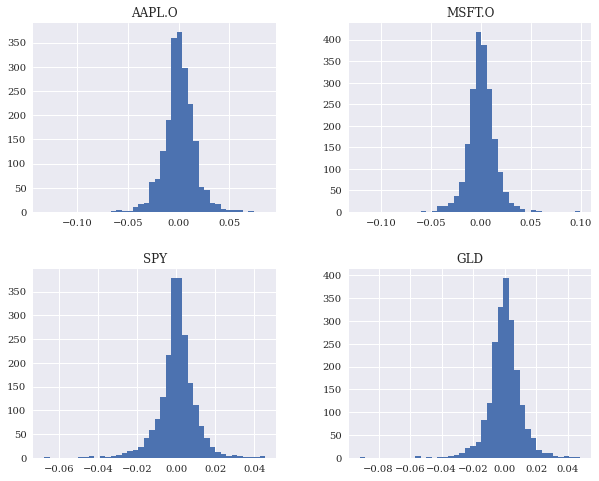

In [ ]:
symbols = ['AAPL.O', 'MSFT.O', 'SPY', 'GLD']
noa = len(symbols)
data = raw[symbols]
rets = np.log(data / data.shift(1))
rets.hist(bins=40, figsize=(10, 8)) 

In [ ]:
rets.mean() * 252

AAPL.O    0.181303
MSFT.O    0.124840
SPY       0.097286
GLD      -0.003784
dtype: float64

In [ ]:
rets.cov() * 252

,AAPL.O,MSFT.O,SPY,GLD
AAPL.O,0.064034,0.023656,0.021154,0.001428
MSFT.O,0.023656,0.051211,0.022390,-0.000370
SPY,0.021154,0.022390,0.022049,0.000108
GLD,0.001428,-0.000370,0.000108,0.025945


In [ ]:
weights = np.random.random(noa)  
weights /= np.sum(weights) 
weights

array([0.42581969, 0.19420457, 0.17983288, 0.20014286])

In [ ]:
weights.sum()

0.9999999999999999

In [ ]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252

In [ ]:
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

In [ ]:
prets = []
pvols = []
for p in range (2500):  
    weights = np.random.random(noa)  
    weights /= np.sum(weights)  
    prets.append(port_ret(weights))  
    pvols.append(port_vol(weights))  
prets = np.array(prets)
pvols = np.array(pvols)

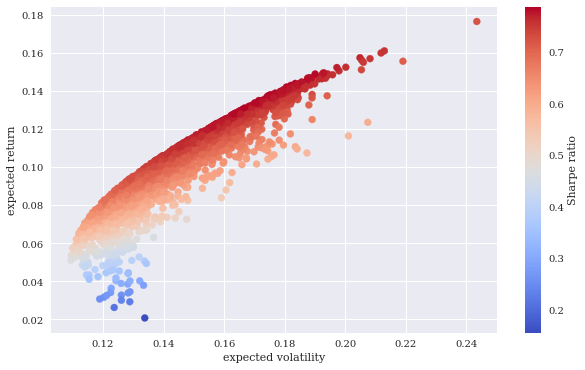

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
            marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');
# plt.savefig('../../images/ch13/stat_12.png')

## Efficient Frontier

In [ ]:
# set the return levels from 5% to 15% and find out the minimum variance point
trets = np.linspace(0.05, 0.15, 50)
# set up the constraint in the optmization model. we assume weights add up to 1
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  
# set up boundary, each weight is within 0 to 100%.
bnds = tuple((0, 1) for x in weights)

In [ ]:
#let's start with four equal weights, because we have only four assets. you can add more assets into this model
eweights = np.array(noa * [1. / noa,])
eweights

array([0.25, 0.25, 0.25, 0.25])

In [ ]:
%%time
tvols = []
import scipy.optimize as sco
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP',
                       bounds=bnds, constraints=cons)  
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 4.71 s, sys: 15.2 ms, total: 4.73 s
Wall time: 5.49 s


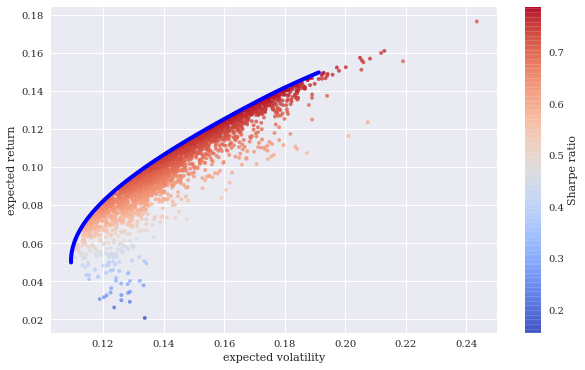

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
            marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
# plt.savefig('../../images/ch13/stat_13.png')

Capital Market Line


In [ ]:
import scipy.interpolate as sci

In [ ]:
ind = np.argmin(tvols)  
evols = tvols[ind:]  
erets = trets[ind:]  

In [ ]:
tck = sci.splrep(evols, erets)  

derived is a linear function t(x) = a + b · x representing the line that passes through the riskless asset in risk-return space and that is tangent to the efficient frontier

In [ ]:
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)

Mathematical conditions for capital market line

t(x) = a + b · x

t(0) = rf ⇔ a = rf

t(x) = f (x) ⇔ a + b · x = f (x)

t '(x) = f '(x) ⇔ b = f '(x)

The equations below describing the capital market line (CML). To this end, define a Python function that returns the values of all three equations given the parameter set p = (a, b, x)

In [ ]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]  
    eq2 = rf + p[1] * p[2] - f(p[2])  
    eq3 = p[1] - df(p[2])  
    return eq1, eq2, eq3

In [ ]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])  

In [ ]:
opt  

array([0.01      , 0.73324949, 0.18212053])

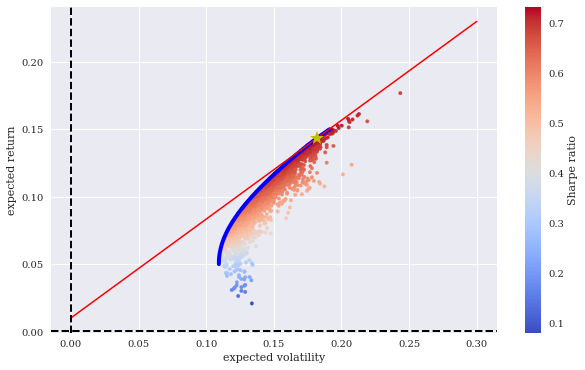

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols,
            marker='.', cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
# plt.savefig('../../images/ch13/stat_14.png')

The portfolio weights of the optimal (tangent) portfolio are as follows. Only three of the four assets are in the mix:



In [ ]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  
res = sco.minimize(port_vol, eweights, method='SLSQP',
                   bounds=bnds, constraints=cons)

In [ ]:
res['x'].round(3)  

array([0.488, 0.191, 0.321, 0.   ])

In [ ]:
port_ret(res['x'])

0.14353978547683255

In [ ]:
port_vol(res['x'])

0.1821204669447605

In [ ]:
port_ret(res['x']) / port_vol(res['x'])

0.7881584529451598